In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from statistics import mean

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_spam

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

from joblib import dump, load
import warnings

warnings.filterwarnings("ignore")

In [67]:
logreg = load('LogReg_final.joblib')
logreg_GAD = load('LogReg_GAD.joblib')
logreg_rf_A = load('ReducedFeatures/logreg_1390_features.joblib')
logreg_rf_B = load('ReducedFeatures/logreg_2290_features.joblib')

In [56]:
imp_scores = np.empty(4, float)

In [51]:
#load imputed data
path = 'ImputedData/'
imputed1 = pd.read_csv (path + 'SimpleImputedFeatures_01.csv', index_col='HHX')
imputed2 = pd.read_csv (path + 'SimpleImputedFeatures_02.csv', index_col='HHX')
imputed3 = pd.read_csv (path + 'SimpleImputedFeatures_03.csv', index_col='HHX')
imputed4 = pd.read_csv (path + 'SimpleImputedFeatures_04.csv', index_col='HHX')
imputed5 = pd.read_csv (path + 'SimpleImputedFeatures_05.csv', index_col='HHX')
imps = [imputed1, imputed2, imputed3, imputed4, imputed5]

#load reduced features data
dataDir = 'FeatureSelection'

dataFile = 'FeatureSelection_cv_results.csv'
path = os.path.join(dataDir, dataFile)
resPD = pd.read_csv(path, index_col=0)

dataFile = 'FeatureSelection_SelectedFeatures.csv'
path = os.path.join(dataDir, dataFile)
selected_features = pd.read_csv(path, index_col=0)

#load test
y_test = pd.read_csv('CleanDataFinal/testTargetFinal.csv', index_col='HHX')


In [58]:
roc_auc_scores = np.empty(5, float)
i = 0
for imp in imps:
    roc_auc_scores[i] = roc_auc_score(y_test, logreg.predict_proba(imp), multi_class='ovr', average='weighted')
    i = i+1

print(roc_auc_scores)
print(mean(roc_auc_scores))
imp_scores[0] = (mean(roc_auc_scores))

[0.49482128 0.48513049 0.48843987 0.49144752 0.48670465]
0.48930876101380905


In [59]:
roc_auc_scores_GAD = np.empty(5, float)

i=0
for imp in imps:
    #repeating previous step to remove GAD columns from testing data
    cols_GAD = imp.columns[imp.columns.str.contains('GAD')]
    imp_GAD = imp.drop(columns=cols_GAD)
    roc_auc_scores_GAD[i] = roc_auc_score(y_test, logreg_GAD.predict_proba(imp_GAD), multi_class='ovr', average='weighted')
    i = i+1

print(roc_auc_scores_GAD)
print(mean(roc_auc_scores_GAD))
imp_scores[1] = (mean(roc_auc_scores_GAD))

[0.45163607 0.43952004 0.44380351 0.44804461 0.44277772]
0.44515638951969044


In [61]:
features_01 = selected_features.FeatureName[selected_features.Ranking == 1].tolist()

roc_auc_scores_rf_A = np.empty(5, float)

i=0
for imp in imps:
    #leave only 1390 best features in data
    rf_cols = imp.columns.intersection(features_01)
    imp_rf = imp[rf_cols]
    roc_auc_scores_rf_A[i] = roc_auc_score(y_test, logreg_rf_A.predict_proba(imp_rf), multi_class='ovr', average='weighted')
    i = i+1

print(roc_auc_scores_rf_A)
print(mean(roc_auc_scores_rf_A))
imp_scores[2] = (mean(roc_auc_scores_rf_A))

[0.70213251 0.70880681 0.70834822 0.70966859 0.70420562]
0.7066323506568353


In [68]:
features_10 = selected_features.FeatureName[selected_features.Ranking <=10].tolist()

roc_auc_scores_rf_B = np.empty(5, float)

i=0
for imp in imps:
    #leave only 2290 best features in data
    rf_cols = imp.columns.intersection(features_10)
    imp_rf = imp[rf_cols]
    roc_auc_scores_rf_B[i] = roc_auc_score(y_test, logreg_rf_B.predict_proba(imp_rf), multi_class='ovr', average='weighted')
    i = i+1

print(roc_auc_scores_rf_B)
print(mean(roc_auc_scores_rf_B))
imp_scores[3] = (mean(roc_auc_scores_rf_B))

[0.61559099 0.61682176 0.6191885  0.61838207 0.61818513]
0.6176336910664247


In [ ]:
# combine scores
#make df
cols = []
for i in np.arange(1, 6):
    c = 'IMP_DSET_' + str(i)
    cols.append(c)
cols.append ('ORIGINAL')

idx = ['FULL', 'NO GAD', '1390_FEATURES', '2290_FEATURES']
scores_df = pd.DataFrame(scores, columns=cols, index=idx)
#add basic stats
scores_imp = scores_df.drop(columns=['ORIGINAL'])
scores_df['IMP_MEAN']=scores_imp.mean(axis=1)
scores_df['IMP_STD']=scores_imp.std(axis=1)
#save data
path = 'ImpTest.csv'
scores_df.to_csv(path)

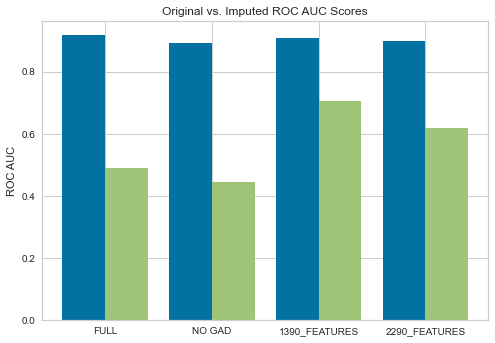

In [69]:
#GRAPH SCORES
idx = ['FULL', 'NO GAD', '1390_FEATURES', '2290_FEATURES']
#these are roc auc scores from each model's original test
og_scores = [0.9176006672, 0.8932196966, 0.906538, 0.89904]

X_axis = np.arange(len(idx))
  
plt.bar(X_axis - 0.2, og_scores, 0.4, label = 'Original Score')
plt.bar(X_axis + 0.2, imp_scores, 0.4, label = 'Imputed Score')
plt.xticks(X_axis, idx)
plt.title("Original vs. Imputed ROC AUC Scores")
plt.ylabel("ROC AUC")
    
plt.show()